In [1]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline

### Getting the Data In

In [2]:
data_file_of_a_slice = pydicom.dcmread('data/P1152/P1152_pCT_20140226_068.dcm')
pixel_array = data_file_of_a_slice.pixel_array #pixel array of ct scan

May want to also try `read_file` function of pydicom (instead of `dcmread` later to see if that makes finding contours easier.

### Exploring the Data

#### Data Type and Shape

This is a **numpy array** of values that indicates the brightness of each pixel. This means all numpy array functions and numpy-compatible libraries (such as sk-image) can be used to analyze.

In [4]:
pixel_array.min()

0

In [5]:
pixel_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [6]:
pixel_array.shape

(512, 512)

#### Exploring the Values of Pixels in the Array

In [7]:
print('The average value of a pixel in the array is {0:.0f}'.format(pixel_array.mean()))
print('The standard deviation of pixel values in the array is {0:.0f}'.format(pixel_array.std()))
print('The minimum value of a pixel in the array {}'.format(pixel_array.min()))
print('The maximum value of a pixel in the array {}'.format(pixel_array.max()))

The average value of a pixel in the array is 211
The standard deviation of pixel values in the array is 369
The minimum value of a pixel in the array 0
The maximum value of a pixel in the array 2314


In [8]:
import math
math.log2(2607) # just checking pixel brightness has to do with the no of bits

11.348174867535556

#### Displaying the Image

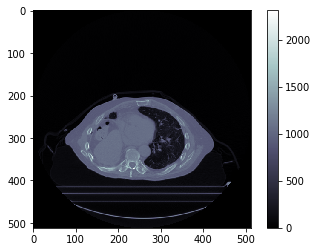

In [9]:
plt.imshow(pixel_array, cmap=plt.cm.bone)  # i like the cm.heat
plt.colorbar()

#### Getting UIDs of All Images

In [10]:
integervalue = 3
'{0:03d}'.format(integervalue)
# image_uids --> sop_instance_ids_of_136_scans
image_uids = [] # data: ids of all images in the dataset
image_locations = [] # data : locations of all slices/images in the dataset
uid_to_filename_map = dict()
uid_to_location_map = dict()
filename = 'data/P1152/P1152_pCT_20140226_'

# making a list of UIDs of all images
# going through all the files
for i in range(1, 137):
    current_filename = filename + '{0:03d}'.format(i) + '.dcm'
    current_file = pydicom.dcmread(current_filename)
    current_uid = current_file.SOPInstanceUID
    current_location = current_file.SliceLocation
    image_uids.append(current_uid)
    uid_to_filename_map[current_uid] = current_filename
    uid_to_location_map[current_uid] = current_location # think about merging these 2 dicts
    image_locations.append(current_file.SliceLocation)  # think about using strings vs integers
    # computational cost.

In [12]:
# just demo
# can use these to match contours to images
image = pydicom.dcmread('data/P1152/P1152_pCT_20140226_043.dcm')
print(image.SliceLocation) #
image.SOPInstanceUID #  can use this to match contours to images

-808.50


'2.16.840.1.114362.1.6.7.5.17616.11849865775.479250700.271.1368'

### Opening Up Contour Data

In [13]:
# contour_file_for_all_136_scans --> cffas
cffas = pydicom.dcmread('data/P1152/P1152_RTStructure_1.dcm')

The contours we need are contained in a feature called `ROIContourSequence`. It is of type Sequence.

In [18]:
cffas.ROIContourSequence[9]
#print(type(cffas.ROIContourSequence))

(3006, 002a) ROI Display Color                   IS: ['0', '255', '0']
(3006, 0040)  Contour Sequence   26 item(s) ---- 
   (3006, 0016)  Contour Image Sequence   1 item(s) ---- 
      (0008, 1150) Referenced SOP Class UID            UI: CT Image Storage
      (0008, 1155) Referenced SOP Instance UID         UI: 2.16.840.1.114362.1.6.7.5.17616.11849865775.479250700.411.1418
      ---------
   (3006, 0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
   (3006, 0046) Number of Contour Points            IS: '111'
   (3006, 0050) Contour Data                        DS: ['13.476989746094', '18.68798828125', '-658.5', '13.593994140625', '18.570007324219', '-658.5', '15.703002929688', '18.570007324219', '-658.5', '15.820007324219', '18.68798828125', '-658.5', '15.820007324219', '18.922027587891', '-658.5', '15.93798828125', '19.039001464844', '-658.5', '16.054992675781', '19.156005859375', '-658.5', '16.054992675781', '19.859008789062', '-658.5', '16.171997070312', '19.977020263672

In [19]:
type(cffas.ROIContourSequence[9].ContourSequence[0].ContourImageSequence[0].ReferencedSOPInstanceUID)

pydicom.uid.UID

In [17]:
cffas.ROIContourSequence[9].ContourSequence[0]
# print(type(cffas.ROIContourSequence))
# here one can see UID and also SliceLocation as 3rd coordinate/height
# metadata on the top, and the contours on the bottom
# The coordinates of the contours are inside DS.

(3006, 0016)  Contour Image Sequence   1 item(s) ---- 
   (0008, 1150) Referenced SOP Class UID            UI: CT Image Storage
   (0008, 1155) Referenced SOP Instance UID         UI: 2.16.840.1.114362.1.6.7.5.17616.11849865775.479250700.411.1418
   ---------
(3006, 0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
(3006, 0046) Number of Contour Points            IS: '111'
(3006, 0050) Contour Data                        DS: ['13.476989746094', '18.68798828125', '-658.5', '13.593994140625', '18.570007324219', '-658.5', '15.703002929688', '18.570007324219', '-658.5', '15.820007324219', '18.68798828125', '-658.5', '15.820007324219', '18.922027587891', '-658.5', '15.93798828125', '19.039001464844', '-658.5', '16.054992675781', '19.156005859375', '-658.5', '16.054992675781', '19.859008789062', '-658.5', '16.171997070312', '19.977020263672', '-658.5', '16.289001464844', '20.093994140625', '-658.5', '16.406005859375', '20.210998535156', '-658.5', '16.523010253906', '20.3280029296

This the first 'set' of contours corresponding to only one point: 'iso LUL'. It seems that the contours sit within 'DS'. How to get at them?

Exploring the Different Kinds of Contours:

In [ ]:
roi_names = []
for structure_set_roi_sequence in iter(cffas.StructureSetROISequence):
    roi_names.append(structure_set_roi_sequence.ROIName)
print(roi_names)

The 9th one is 'GTV FREE'

Look at the image:

In [ ]:
current_uid = cffas.ROIContourSequence[9].ContourSequence[0].ContourImageSequence[0].ReferencedSOPInstanceUID
found_filename = uid_to_filename_map[current_uid] # correct image 

found_filename

In [ ]:
data_file_of_CT_scan_with_first_contour = pydicom.dcmread(found_filename)
pixel_array_of_first_contour = data_file_of_CT_scan_with_first_contour.pixel_array
pixel_array_of_first_contour

In [ ]:
pixel_array_of_first_contour.shape

In [ ]:
found_filename

In [ ]:
data_file_of_last_slice_of_CT_scan = pydicom.dcmread(found_filename)
pixel_array = data_file_of_last_slice_of_CT_scan.pixel_array #pixel array of ct scan

In [ ]:
pixel_array

plt.imshow(pixel_array, cmap=plt.cm.bone)  # i like the cm.heat
plt.colorbar()

In [ ]:
len(cffas.ROIContourSequence[9].ContourSequence[0].ContourData)

How to convert the coordinates to other coordinates:

Two things left: 

* Convert the coordinates to pixels.
* Check that these are the correct pixels. (well I already checked)
* Here I used the dicompyler UI to figure out what the ends are for the images. Will this always work?
* Also are these all the pixels that fall within the contours or just the boundary?

##### Observing that 
for X coordinates:
0th pixel is -300mm.
511th pixel is 298.83mm.

for Y coordinates:
0th pixel is -271mm.
511th pixel is 327.83mm

In [ ]:
min_x = -300
max_x = 298.83
298.83+300

In [ ]:
gap

In [ ]:
327.83+271

The sum is that.

In [ ]:
total_length = 298.83+300

In [ ]:
gap = total_length/511 # ~1.17

Of course there is going to be some rounding issues.

Let's convert an x coordinate to a pixel number:

Starts with -300, and ends with 298.83

In [ ]:
sample_3d_coordinates = cffas.ROIContourSequence[9].ContourSequence[0].ContourData[:3]

In [ ]:
sample_3d_coordinates

In [ ]:
sample_3d_coordinates_digits = [float(n) for n in sample_3d_coordinates ]

In [ ]:
sample_3d_coordinates_digits

In [ ]:
(sample_3d_coordinates_digits[1]+300)/gap

In [ ]:
cffas.ROIContourSequence[9].ContourSequence[0].ContourData

In [ ]:
gap = 1.171875

In [ ]:
(13.476989746094 + 300)/gap

In [ ]:
all_contours = cffas.ROIContourSequence[9].ContourSequence[0].ContourData

In [ ]:
all_x_contours = all_contours[0::3]

In [ ]:
all_y_contours = all_contours[1::3]

In [ ]:
all_contours[2]

In [ ]:
(x_coord - x_start)/gap

In [ ]:
all_x_contours

In [ ]:
all_x_contours + 

In [ ]:
x_pixels = []
for x_coord in all_x_contours:
    x_pixels.append(round((x_coord - x_start)/gap))

In [ ]:
all_y_

In [ ]:
y_pixels = []
for y_coord in all_y_contours:
    y_pixels.append(round((y_coord - y_start)/gap))

In [ ]:
y_pixels

In [ ]:
all_pixels = list(zip(x_pixels, y_pixels))

What I need to do here is to display the matrix so that these coordinates are multiplied by 1, and the others are multiplied by 0.

In [ ]:
all_pixels

In [ ]:
import numpy as np
test_array = np.zeros([512,512])

In [ ]:
test_array[0,0]

In [ ]:
test_array[260:270, 240:280]

In [ ]:
np.zeros(5)
for a_pixel in all_pixels:
    test_array[a_pixel[0], a_pixel[1]] = pixel_array_of_first_contour[a_pixel[0], a_pixel[1]]

In [ ]:
test_array

In [ ]:
plt.imshow(test_array[260:280, 230:260], cmap=plt.cm.bone)  

Are these the boundaries or the pixels themselves?

I think I came to the point where I need to figure out the points that fall within a boundary... using distance function....

But first let's see what happens to these coordinates when we plot them?

In [ ]:
all_pixels

In [ ]:
a

In [ ]:
gap = 1.71875

In [ ]:
x_start = -300
y_start = -271

So each pixel is associated with an x and a y.

In [ ]:
cffas.ROIContourSequence[9].ContourSequence[0].ContourData

In [ ]:
cffas.ROIContourSequence[9] #.ContourSequence[0]

In [ ]:
dir(cffas.ROIContourSequence[9].ContourSequence[0].ContourImageSequence[0].ReferencedSOPInstanceUID[0])

In [ ]:
cffas.ROIContourSequence[9].ContourSequence[0].ContourImageSequence[0].ReferencedSOPInstanceUID

In [ ]:
cffas.ROIContourSequence[9].ContourSequence[0]

In [ ]:
cffas.ROIContourSequence[9].ContourSequence[0]

In [ ]:
cffas.ROIContourSequence[9].ContourSequence[0]

#### Let's Match the Contours to the Slices

Contours

It seems that this is a sequence of contours, and I can access individual units of these by calling `ContourSequence[i]`

In [ ]:
#aics1 --> "All Images in ContourSequence[1]"
aics1 = []
for structure in iter(cffas.ROIContourSequence[1].ContourSequence):
    aics1.append(structure.ContourImageSequence[0].ReferencedSOPInstanceUID)

In [ ]:
len(set(aics1))

Checking if all the images associated with the contours are ones we know

In [ ]:
among_images = True
for image_name in aics1:
    if image_name not in image_uids:
        among_images = False
        print('problem')

#### Let's do this check for all Contour Sets:

In [ ]:
len(cffas.ROIContourSequence[2].ContourSequence)

In [ ]:
cffas.ROIContourSequence[i].ContourSequence[27].ContourImageSequence[0].ReferencedSOPInstanceUID

In [ ]:
# def check_contour_images_known(contour_index):
#     aics = []
#     for structure in iter(cffas.ROIContourSequence[contour_index].ContourSequence):
#         aics.append(structure.ContourImageSequence[0].ReferencedSOPInstanceUID)

In [ ]:
#for cs in iter(cffas.ROIContourSequence[2].ContourSequence):
#    print(cs.ContourImageSequence[0].ReferencedSOPInstanceUID)

In [ ]:
cffas.ROIContourSequence[1].ContourSequence[0].ContourImageSequence[0].ReferencedSOPInstanceUID

# ROIContourSequence has the different colors/kinds of sequences.
# ContourSequence ; has the different contours that correspond to different images/structures on images + metadata

#### ContourData Itself

In [ ]:
type(cffas.ROIContourSequence[1].ContourSequence[26].ContourData)

In [ ]:
# How to access the coordinates
cffas.ROIContourSequence[1].ContourSequence[26].ContourData[:6]

In [ ]:
cffas.ROIContourSequence[1].ContourSequence[26].ContourData[2]

This is a way of accessing the contour data. They are not organized the best way, with no recognition of the fact that these are 3D coordinates. Need to be converted to floats and probably to coordinates. 

In [ ]:
# ContourData is like a list of coordinates
print("How many Contour Points do we have? {}".format(
      cffas.
      ROIContourSequence[1].ContourSequence[26].NumberOfContourPoints))
print("How many coordinates are expected for {} contour points? {}".format(
      cffas.
      ROIContourSequence[1].ContourSequence[26].NumberOfContourPoints,
      3*int(cffas.
            ROIContourSequence[1].ContourSequence[26].NumberOfContourPoints)))
print("How many coordinates do we have in ContourData? {}".format(
        len(cffas.
            ROIContourSequence[1].ContourSequence[26].ContourData)))

In [ ]:
len(cffas.ROIContourSequence[1].ContourSequence[27].ContourData)

In [ ]:
cffas.ROIContourSequence[1].ContourSequence[27].ContourImageSequence[0]

In [ ]:
cffas.ROIContourSequence[1].ContourSequence[27].ContourImageSequence[0].ReferencedSOPInstanceUID

How to map the contours to the images?

data_file_of_last_slice_of_CT_scan.SOPInstanceUID

Note that `ContourSequence[26]` and `27` both have the same slice height, and the `ContourImageSequence[0]` gives the same value for both of them.

How to match the slices to the images
Is it true that the ContourSequences refer to the same z-height sometimes because they are multiple structures.
Check the images and get the contours.
also if there so multiple structures on an image, there should be way more than 29 images right?


#### Outstanding Questions

* Why are there 32 of these Sequences?
    * One would have thought that there are 32 slices for the first ContourSequence but that is not the case.

* Check if the metadata `ContourImageSequence[0]` matches metadata of images themselves. That would enable mapping.

* How to look at dicompyler source code to see how it solves this problem of matching contours to images.

**** Check Assumptions:
Are all the z-coordinates in a ContourSequence dataset/list the same? If they are, that is great.
Print the SOIP UID of all images.

*Try to find the mapping of the ROIContourSequences to the Contours such as RT LUNG, GTV FREE etc.

MetaData Analysis

ReferencedStudySequence

In [ ]:
cffas.ReferencedStudySequence[0]

The SOPInstanceUID is different from others but very close! (Ask Mohamed what this may mean?)

In [ ]:
cffas.SOPClassUID #we do not need this. this is something completely different.

In [ ]:
cffas.SOPInstanceUID

*What is Reference 'Study' and Is Its SOP Instance one of the Scans?*

Find a way to make 3d visualizations of the contours. Irem's idea.

In [ ]:
test = cffas.ReferencedStudySequence[0].ReferencedSOPInstanceUID
#test in sop_instance_ids_of_136_scans

Combine multiple slices / contours so that the structure/tumor (etc 'lung') is visible as a 3d object.

#### Let's Draw the Contours on One Image

In [ ]:
dir(cffas.ROIContourSequence[1].ContourSequence[0])

In [ ]:
cffas.ROIContourSequence[1].ContourSequence[0].ContourImageSequence[0]

In [ ]:
image_id = cffas.ROIContourSequence[1].ContourSequence[0].ContourImageSequence[0].ReferencedSOPInstanceUID
#dir(cffas.ROIContourSequence[1].ContourSequence[0].ContourImageSequence)

In [ ]:
image_id

How am I going to find the average brightness of pixels within the 

Check why the brightness is not the same in dicompyler as in the program.